# Section 1. Getting Started

##1.1 Introduction Jupyter notebook
In a Jupyter notebook, **Cells** are Python code chunks that you can run interactively.


First, make a copy of this notebook to your Google drive:
- Navigate to "**File**" → "**Save a copy in...**"

To run the notebook, there are two options:
1.   connect to a **hosted** runtime, i.e. a remote virtual machine (**recommended**);
2.   connect to your **local** runtime.

You can configure this at the top right corner of this page:

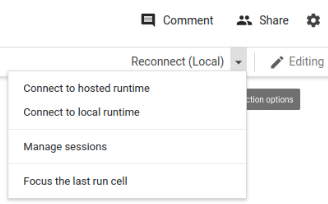






After setting up the runtime, try this one below:

In [ ]:
print('Hello from Praktikum ST.')

Hello from Praktikum ST.


Before starting, let's list the available packages in the environment.

Verify that **`torch`** is there, since we'll need it for training our models.

In [ ]:
!pip install pip==24.0
!pip list -v

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.0 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Package                            Version              Location                                Installer
---------------------------------- -------------------- --------------------------------------- ---------
absl-py                            1.4.0                /usr/local/lib/python3.10/dist-packages uv
accelerate                         0.34.2               /usr/local/lib/python3.10/dist-packages uv
aiohappyeyeballs                   2.4.3                /usr/local/lib/python3.10/dist-packages uv
aiohttp                            3.10.10              /usr/local/lib/python3.10/dist-packages uv
aiosignal                          1.3.1                /usr/local/lib/python3.10/dist-packages uv
alabaster                          0.7.16               /usr/local/lib/py

## 1.2 Enabling and testing the GPU

When training your model, having a GPU is convenient, as the training can be well parallelized.

First, let's enable GPUs for this notebook:

- Navigate to "**Edit**" → "**Notebook Settings**"
- Select GPU from the **Hardware Accelerator** list

Next, we'll check if we can connect to the GPU with PyTorch:

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(device))
else:
    print('Failed to find GPU. Will use CPU.')
    device = 'cpu'

Current device: Tesla T4


## 1.3 What are we doing for this lab?

We will first walk through an example of training an English-to-German text-to-text translation model.

We will use the [fairseq](https://github.com/facebookresearch/fairseq) toolkit [(Ott et al., 2019)](https://aclanthology.org/N19-4009.pdf).

Afterwards, you will build a translation model for a translation direction of your choice.

## 1.4 Saving local files (only relevant when using Colab)

If you are working with a **hosted** runtime, your local files (including the trained models!) will be **removed** when you disconnect the runtime.

To save these files, you might want to **mount** your Google Drive as local storage (see Section 6.1 for details).

A downside, however, is that the storage is capped by your Google drive **storage limit**.


## 1.5 Installing fairseq

In [ ]:
# Cloing fairseq repo from github
!git clone https://github.com/facebookresearch/fairseq.git

Cloning into 'fairseq'...
remote: Enumerating objects: 35385, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 35385 (delta 10), reused 38 (delta 10), pack-reused 35337 (from 1)
Receiving objects: 100% (35385/35385), 25.47 MiB | 19.38 MiB/s, done.
Resolving deltas: 100% (25538/25538), done.


After cloing the repo, we will install fairseq as a library:

In [ ]:
%cd fairseq
!pip install --editable ./

/content/fairseq
Obtaining file:///content/fairseq
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 kB 9.2 MB/s eta 0:00:00
  Building editable for fairseq (pyproject.toml) ... done
  Created wheel for fairseq: filename=fairseq-0.12.2-0.editable-cp310-cp310-linux_x86_64.whl size=9554 sha256=30964ebafc37a3ceae98f7ab559fd62b56376fab49547fac4d24a57118faf4e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ig1lrgcj/wheels

Add fairseq to Python path:

In [ ]:
!echo $PYTHONPATH

import os
os.environ['PYTHONPATH'] += ":/content/fairseq/"

!echo $PYTHONPATH

/env/python
/env/python:/content/fairseq/


We also need some other libraries:

In [ ]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 8.8 MB/s eta 0:00:00
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


# Section 2. Data Preparation


Before training we first preprocess the data.

In [ ]:
%cd /content/fairseq/examples/translation

/content/fairseq/examples/translation


Let's fetch some sample data.

The data are TED talk transcripts (English) and translations (German) from the evaluation campaign [IWSLT 2014](https://aclanthology.org/2014.iwslt-evaluation.1.pdf).

In [ ]:
!wget -nc -O sample_data.zip https://bwsyncandshare.kit.edu/s/7oo2AG8jRriLZKg/download?path=%2F&files=data.zip&downloadStartSecret=tk6qdncox5
!unzip sample_data.zip

--2024-10-23 08:58:01--  https://bwsyncandshare.kit.edu/s/7oo2AG8jRriLZKg/download?path=%2F
Resolving bwsyncandshare.kit.edu (bwsyncandshare.kit.edu)... 141.3.135.129, 2a00:1398:b::8d03:8781
Connecting to bwsyncandshare.kit.edu (bwsyncandshare.kit.edu)|141.3.135.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘sample_data.zip’

sample_data.zip         [       <=>          ]   2.19G  8.70MB/s    in 3m 33s  

2024-10-23 09:01:36 (10.5 MB/s) - ‘sample_data.zip’ saved [2350518515]

Archive:  sample_data.zip
   creating: sample_data/
   creating: sample_data/2014-01/
   creating: sample_data/2014-01/scores/
   creating: sample_data/2014-01/scores/ar/
   creating: sample_data/2014-01/scores/ar/en/
 extracting: sample_data/2014-01/scores/ar/en/.info  
 extracting: sample_data/2014-01/scores/ar/en/IWSLT14.TED.tst2010.ar-en.ar.tok_3.0.trans  
   creating: sample_data/2014-01/scores/de/
   creating: sample_data/2014-01/scores

In [ ]:
# List files in downloaded `sample_data`
!ls -ltr sample_data

!echo -e "\nFirst lines of English:\n"
!head sample_data/train.de-en.en
!echo -e "\nFirst lines of German:\n"
!head sample_data/train.de-en.de

total 1116788
-rw-r--r-- 1 root root     199632 Oct 24  2022 dev.de-en.en
-rw-r--r-- 1 root root     223089 Oct 24  2022 dev.de-en.de
-rw-r--r-- 1 root root     418647 Oct 24  2022 tst.de-en.en
-rw-r--r-- 1 root root     473219 Oct 24  2022 tst.de-en.de
-rw-r--r-- 1 root root   18496311 Oct 24  2022 train.de-en.de
-rw-r--r-- 1 root root   16663248 Oct 24  2022 train.de-en.en
-rw-r--r-- 1 root root   13535860 Oct 24  2022 data.zip
-rw-r--r-- 1 root root 1093557157 Feb 29  2024 2014-01.tgz
drwxr-xr-x 7 root root       4096 Oct 23 08:58 2014-01

First lines of English:

It can be a very complicated thing, the ocean.
And it can be a very complicated thing, what human health is.
And bringing those two together might seem a very daunting task, but what I'm going to try to say is that even in that complexity, there's some simple themes that I think, if we understand, we can really move forward.
And those simple themes aren't really themes about the complex science of what's going on, but thin

We segment the text into *subwords* using *byte pair encoding* [(BPE; Sennrich et al. 2017)](https://aclanthology.org/P16-1162.pdf).

We will use the [sentencepiece](https://github.com/google/sentencepiece) package to segment the subwords.




In [ ]:
!pip install sentencepiece

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
import sentencepiece as spm

spm.SentencePieceTrainer.train(input="sample_data/train.de-en.en,sample_data/train.de-en.de",
                               model_prefix="bpe",
                               vocab_size=10000)

print('Finished training sentencepiece model.')

Finished training sentencepiece model.


Now we use the trained segmentation model to preprocess the sentences from train/dev/test sets:

In [ ]:
# Load the trained sentencepiece model
spm_model = spm.SentencePieceProcessor(model_file="bpe.model")

for partition in ["train", "dev", "tst"]:
    for lang in ["de", "en"]:
        f_out = open(f"sample_data/spm.{partition}.de-en.{lang}", "w")

        with open(f"sample_data/{partition}.de-en.{lang}", "r") as f_in:
            for line_idx, line in enumerate(f_in.readlines()):
                # Segmented into subwords
                line_segmented = spm_model.encode(line.strip(), out_type=str)
                # Join the subwords into a string
                line_segmented = " ".join(line_segmented)
                f_out.write(line_segmented + "\n")

        f_out.close()

Now check the first lines of the segmented sentences.

❓ Do you observe any patterns?

In [ ]:
# Your code here

❓ What would be the problem when we use whole words instead of subwords?

Now, we will binarize the data for training with fairseq.

In [ ]:
# Preprocess/binarize the data
TEXT="/content/fairseq/examples/translation/sample_data"
!echo $TEXT
# Binarize the data for training
!fairseq-preprocess \
    --source-lang en --target-lang de \
    --trainpref $TEXT/spm.train.de-en \
    --validpref $TEXT/spm.dev.de-en \
    --testpref $TEXT/spm.tst.de-en \
    --destdir data-bin/iwslt14.de-en \
    --thresholdtgt 0 --thresholdsrc 0 \
    --workers 8

/content/fairseq/examples/translation/sample_data
2024-10-23 09:03:47.036921: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 09:03:47.275467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 09:03:47.342093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 09:03:47.756996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler fl

Feel free to check the [documentation](https://fairseq.readthedocs.io/en/latest/command_line_tools.html) of fairseq commands.

# Section 3. Training

After data preparation, it's time do train a model!

We will train a [Transformer (Vaswani et al. 2017)](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) model of "base" configuration.

This will be the most time-consuming step out of all sections.

With our data, on a Tesla T4 GPU, one epoch will take around 3 minutes.



❓ Check the training log to answer the following question:
* How many sentence pairs are there in the training and dev set?
* How many encoder layers are there?
* How many decoder layers are there?
* What is the vocabulary size for the source and target language?
* What is the size of the embedding table of the source and target language?
* How many parameters does the model have?
    * How many of them are trainable?
* What type of training objective (criterion) is used?
* How does the learning rate (`lr`) change as training goes further?
    * What do you think is the intuition behind this?

In [ ]:
!CUDA_VISIBLE_DEVICES=0 fairseq-train \
    /content/fairseq/examples/translation/data-bin/iwslt14.de-en \
    --arch transformer --share-decoder-input-output-embed \
    --optimizer adam --adam-betas '(0.9, 0.98)' --clip-norm 0.0 \
    --lr 5e-4 --lr-scheduler inverse_sqrt --warmup-updates 4000 \
    --dropout 0.3 --weight-decay 0.0001 \
    --criterion label_smoothed_cross_entropy --label-smoothing 0.1 \
    --keep-last-epochs 2 \
    --max-tokens 4096 \
    --max-epoch 20 \
    --fp16

2024-10-23 09:05:53.807745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 09:05:53.841492: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 09:05:53.851409: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 09:05:53.873730: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 09:05:55.324171: W tensorflow/comp

# Section 4. Decoding

Now we can generate translations with the trained model.

In [ ]:
TEST_INPUT="/content/fairseq/examples/translation/sample_data/spm.tst.de-en.de"
PRED_LOG="/content/fairseq/examples/translation/en-de.decode.log"

!fairseq-generate /content/fairseq/examples/translation/data-bin/iwslt14.de-en \
      --task translation \
      --source-lang en \
      --target-lang de \
      --path /content/fairseq/examples/translation/checkpoints/checkpoint_best.pt \
      --batch-size 256 \
      --beam 4 \
      --remove-bpe=sentencepiece > $PRED_LOG

2024-10-23 09:11:29.661382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 09:11:29.681449: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 09:11:29.687463: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 09:11:29.703231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 09:11:30.832584: W tensorflow/comp

We extract the hypotheses and references from the decoding log file.

In [ ]:
!grep ^H $PRED_LOG | sed 's/^H-//g' | cut -f 3 | sed 's/ ##//g' > ./hyp.txt
!grep ^T $PRED_LOG | sed 's/^T-//g' | cut -f 2 | sed 's/ ##//g' > ./ref.txt

In [ ]:
!head ./hyp.txt
!head ./ref.txt

Das ist: Ja.
Sie haben sie sie sie.
Wir haben wir uns die Welt. Wir werden.
Und ich glaube, dass ich glaube.
Was das ist, was sie?
Ich habe sie sie sie sie zu tun.
Er sagte: "Ich sagte: "Ich sagte: "Ich sagte: "Ich sagte."
Was ist die Frage?
Und es ist es?
Sie sagte: "Ich sagte."
DK: 60.000.
Bewerte sie wieder.
Wir heben ab.
Ich dachte darüber nach.
Was brauchen diese Menschen?
Ich wollte sie unterstützten.
"Ja", sagte er.
Wer ist am erfolgreichsten?
Und warum ist das so?
So fühlen sie sich gut."


# Section 5. Evaluation

To evaluate the generated translation, a common metric is **BLEU** (**B**i**L**ingual **E**valuation **U**nderstudy; [Papineni et al., 2002](https://aclanthology.org/P02-1040.pdf)).

BLEU is based on the overlaps between the MT system's output (a.k.a **hyptheses**) against **reference** translations.

## 5.1 sacreBLEU
A widely-used toolkit for evaluating BLEU is [sacreBLEU](https://pypi.org/project/sacrebleu/) [(Post, 2018)](https://aclanthology.org/W18-6319.pdf).

To intall sacrebleu in your environment:

In [ ]:
!pip install sacrebleu

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


## 5.2 Evaluating Your System

In [ ]:
!cat ./hyp.txt | sacrebleu ref.txt

{
 "name": "BLEU",
 "score": 1.3,
 "signature": "nrefs:1|case:mixed|eff:no|tok:13a|smooth:exp|version:2.4.3",
 "verbose_score": "17.1/3.0/0.6/0.1 (BP = 1.000 ratio = 1.635 hyp_len = 140120 ref_len = 85699)",
 "nrefs": "1",
 "case": "mixed",
 "eff": "no",
 "tok": "13a",
 "smooth": "exp",
 "version": "2.4.3"
}


Decode your model with difference beam sizes and evaluate the BLEU scores.

| Beam Size | BLEU |
|---|---|
| 1 (greedy decoding)  |   |
| 2  |   |  
| 4  |   |  
| 8  |   |  
| 16  |   |

# Section 6. Next Steps

## 6.1 Saving Local Files
To save files in from the hosted runtime to your local storage, you can use the following code to mount your Google Drive:

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
# Go to your drive
%cd /content/drive/MyDrive
# Make directory named ST1
!mkdir -p ST1
# Go to the newly created directory
%cd ST1

MessageError: Error: credential propagation was unsuccessful

After that, you can use `cp` to copy files from the hosted runtime to your local storage.

## 6.2 Action Items
* Send me the members of your group

* Decide on the translation direction(s) your team would like to work on. Some sources of parallel data include:
    * [OPUS](https://opus.nlpl.eu/)
    * [MuST-C](https://ict.fbk.eu/must-c/)
* Train a machine translation model for your chosen direction(s).
* Send me your lab report 2 days before the next session. When compiling the report, consider including the following information:
    * **dataset** information (which corpus; size of train / dev / test sets)
    * model **architecture**
    * **performance** on dev and test sets
    * **One page** should be enough to cover the important information
    * mail to Tu Anh Dinh tu.dinh@kit.edu

## 6.3 ❓ Food for Thought
* So far, we assume the inputs to the MT system are **error-free** (i.e. fully accurate transcription of the spoken utterances). What would happen when the text comes out of an **ASR system**? What would be the impact on the MT performance?
* When handling audio inputs, which part of the model can we **keep**, and which needs to be **adapted**?